# 

# San Francisco Crime Classification

Predict the category of crimes that occurred in the city by the bay

This dataset contains incidents derived from SFPD Crime Incident Reporting system. The data ranges from 1/1/2003 to 5/13/2015.  

Data fields: 
* Dates - timestamp of the crime incident
* Category - category of the crime incident (only in train.csv). This is the target variable you are going to predict.
* Descript - detailed description of the crime incident (only in train.csv)
* DayOfWeek - the day of the week
* PdDistrict - name of the Police Department District
* Resolution - how the crime incident was resolved (only in train.csv)
* Address - the approximate street address of the crime incident 
* X - Longitude
* Y - Latitude

Orginal Dataset: https://www.kaggle.com/c/sf-crime/data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SQLContext, SparkSession
spark = SparkSession.Builder().appName('Project').getOrCreate()

In [2]:
from pyspark.sql.functions import count, countDistinct, length, hour, year, month, date_format, desc, dayofweek, col 
from pyspark.sql import functions as F

### Sampling of the original dataset

In [3]:
# import pandas as pd

# lst_filter = [
#  'ASSAULT',
#  'DRUG/NARCOTIC',
#  'VEHICLE THEFT',
#  'VANDALISM']

# df_dataset = pd.read_csv("train.csv", header='infer')
# print("Orginal size", len(df_dataset))
# df_dataset = df_dataset[df_dataset["Category"].isin(lst_filter)] 
# print("After filter size", len(df_dataset))
# df_sample = df_dataset.sample(n=50000, random_state=4, replace=False)
# print("After sample", len(df_sample))
# df_sample.to_csv("crimes_sf.csv", index=False)


## Part 1. Data Exploration

Q. Read the csv "crimes_sf.csv" as a PySpark DataFrame

In [4]:
file = 'crimes_sf.csv'
df_crimes = spark.read.csv(file, header = True, inferSchema = True)


Q. Show the first 5 rows in the file

In [5]:
df_crimes.show(5)

+-------------------+---------+--------------------+---------+----------+--------------+--------------------+-----------------+------------------+
|              Dates| Category|            Descript|DayOfWeek|PdDistrict|    Resolution|             Address|                X|                 Y|
+-------------------+---------+--------------------+---------+----------+--------------+--------------------+-----------------+------------------+
|2005-05-31 13:30:00|  ASSAULT|AGGRAVATED ASSAUL...|  Tuesday|   MISSION|ARREST, BOOKED|2300 Block of FOL...| -122.41469551481|  37.7596861764245|
|2011-05-22 22:00:00|  ASSAULT|CHILD, INFLICTING...|   Sunday|   TARAVAL|ARREST, BOOKED|200 Block of SANT...|-122.462826575708|  37.7361073849138|
|2005-11-14 13:00:00|  ASSAULT|             BATTERY|   Monday|   MISSION|          NONE|500 Block of LIBE...|-122.433540925286|  37.7570071557685|
|2012-02-24 05:03:00|  ASSAULT|AGGRAVATED ASSAUL...|   Friday|TENDERLOIN|          NONE|   HYDE ST / EDDY ST|-122.4158

Q. Convert only the first 5 rows into a pandas dataframe

In [6]:
df_crimes.limit(5).toPandas()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2005-05-31 13:30:00,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Tuesday,MISSION,"ARREST, BOOKED",2300 Block of FOLSOM ST,-122.414696,37.759686
1,2011-05-22 22:00:00,ASSAULT,"CHILD, INFLICTING INJURY RESULTING IN TRAUMATI...",Sunday,TARAVAL,"ARREST, BOOKED",200 Block of SANTAPAULA AV,-122.462827,37.736107
2,2005-11-14 13:00:00,ASSAULT,BATTERY,Monday,MISSION,NONE,500 Block of LIBERTY ST,-122.433541,37.757007
3,2012-02-24 05:03:00,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Friday,TENDERLOIN,NONE,HYDE ST / EDDY ST,-122.415885,37.783516
4,2009-11-25 23:50:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Wednesday,BAYVIEW,NONE,3RD ST / WILLIAMS AV,-122.392625,37.729280


Q. Verify the column schema of the dataframe using printSchema

In [7]:
df_crimes.printSchema()

root
 |-- Dates: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)



Q. Rename the columns "X" and "Y" to "Lng" and "Lat" respectively

In [8]:
df_crimes = df_crimes.withColumnRenamed("X","Lng").withColumnRenamed("Y","Lat")


Q. Count the number of distinct crime categories

In [9]:
df_crimes.select(countDistinct("Category")).show()

+------------------------+
|count(DISTINCT Category)|
+------------------------+
|                       4|
+------------------------+



Q. Show all the Category values in the dataset

In [10]:
df_crimes.select("Category").distinct().show()

+-------------+
|     Category|
+-------------+
|      ASSAULT|
|    VANDALISM|
|DRUG/NARCOTIC|
|VEHICLE THEFT|
+-------------+



Q. Compute the number of crimes in the NORTHERN PdDistrict

In [11]:
df_crimes.filter(df_crimes["PdDistrict"] == "NORTHERN").count()

5354

In [12]:
df_crimes.where(df_crimes.PdDistrict == "NORTHERN").count()


5354

Q. Frequency distribution of crimes by category

In [13]:
category_counts = df_crimes\
                    .groupBy("Category")\
                    .agg(count("Category").alias("crime_count_per_category"))\
                    .orderBy(desc("crime_count_per_category")).toPandas()


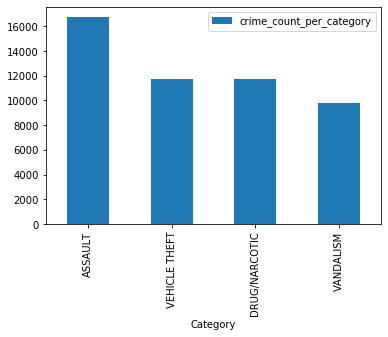

In [14]:
category_counts.set_index(keys=["Category"]).plot(kind="bar")

Q. Create the columns hour, month and year based on the column Dates

In [15]:
df_crimes.limit(5).select("*").toPandas()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,Lng,Lat
0,2005-05-31 13:30:00,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Tuesday,MISSION,"ARREST, BOOKED",2300 Block of FOLSOM ST,-122.414696,37.759686
1,2011-05-22 22:00:00,ASSAULT,"CHILD, INFLICTING INJURY RESULTING IN TRAUMATI...",Sunday,TARAVAL,"ARREST, BOOKED",200 Block of SANTAPAULA AV,-122.462827,37.736107
2,2005-11-14 13:00:00,ASSAULT,BATTERY,Monday,MISSION,NONE,500 Block of LIBERTY ST,-122.433541,37.757007
3,2012-02-24 05:03:00,ASSAULT,AGGRAVATED ASSAULT WITH A DEADLY WEAPON,Friday,TENDERLOIN,NONE,HYDE ST / EDDY ST,-122.415885,37.783516
4,2009-11-25 23:50:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM",Wednesday,BAYVIEW,NONE,3RD ST / WILLIAMS AV,-122.392625,37.729280


In [16]:
df_crimes = df_crimes.withColumn("Hour", hour("Dates"))\
                     .withColumn("Month", date_format("Dates", "MM"))\
                     .withColumn("Year", year("Dates")) 

df_crimes.printSchema()

root
 |-- Dates: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Lng: double (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)



Q. Min and Max dates of the crimes in the dataset

In [17]:
df_crimes.select(F.min("Dates"),F.max("Dates")).limit(4).show()

+-------------------+-------------------+
|         min(Dates)|         max(Dates)|
+-------------------+-------------------+
|2003-01-06 01:30:00|2015-05-13 19:28:00|
+-------------------+-------------------+



Q. Visualize crime occurances over the months for the crimes of ASSAULT and VANDALISM. 

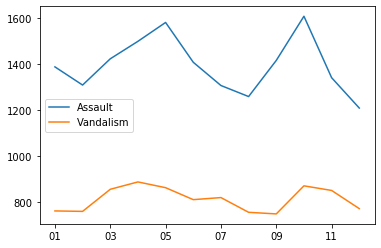

In [18]:
crimes_over_month = df_crimes.filter((df_crimes.Category=="ASSAULT") | (df_crimes.Category=="VANDALISM"))\
            .groupBy(["Month", "Category"])\
            .agg(count("Category").alias("Count"))\
            .sort(col("Month").asc()) 

df = crimes_over_month.toPandas()
d = {
    "Assault": df[df["Category"]=="ASSAULT"]["Count"].to_list(),
    "Vandalism": df[df["Category"]=="VANDALISM"]["Count"].to_list()
}
pd.DataFrame(d, index=df["Month"].unique()).plot()



In [19]:
crimes_over_month.toPandas()[:10]

,Month,Category,Count
0,01,VANDALISM,762
1,01,ASSAULT,1388
2,02,ASSAULT,1309
3,02,VANDALISM,760
4,03,VANDALISM,856
5,03,ASSAULT,1423
6,04,ASSAULT,1499
7,04,VANDALISM,888
8,05,VANDALISM,863
9,05,ASSAULT,1581


Q. Visualize the crime occurences per each day of the week. Use SQL syntax. 

In [20]:

df_crimes.registerTempTable('crimes')
by_dayOfWeek = spark.sql('select DayOfWeek, count(*) as count from crimes group by DayOfWeek limit 10')
by_dayOfWeek.show()


+---------+-----+
|DayOfWeek|count|
+---------+-----+
|Wednesday| 7246|
|  Tuesday| 6851|
|   Friday| 7509|
| Thursday| 7069|
| Saturday| 7393|
|   Monday| 6923|
|   Sunday| 7009|
+---------+-----+



Q. Show the streets with more than 5 "VEHICLE THEFT" crimes between the years of 2012 and 2015.

In [21]:

df_crimes.registerTempTable('crimes')
df_query = spark.sql('select Address, count(*) as count \
                            from crimes \
                            where Category == "VEHICLE THEFT" and Year between 2012 and 2015 \
                            group by Address \
                            having count(*) > 5 \
                            limit 10')
df_query.show()


+--------------------+-----+
|             Address|count|
+--------------------+-----+
|200 Block of INTE...|    7|
|400 Block of STOC...|   12|
+--------------------+-----+



Q. Top 10 most frequent words in the crimes description. Hint: convert the Column Descript into a rdd.

In [22]:
rdd_descriptions = df_crimes.select("Descript").rdd.map(lambda x: list(x))
rdd_descriptions.flatMap(lambda l: [(w,1) for w in l[0].split()]) \
        .reduceByKey(lambda x,y: x+y) \
        .takeOrdered(10, lambda t: -t[1])

[('OF', 15624),
 ('MALICIOUS', 9637),
 ('MISCHIEF,', 9531),
 ('POSSESSION', 9401),
 ('STOLEN', 9296),
 ('VANDALISM', 7392),
 ('BATTERY', 6415),
 ('AUTOMOBILE', 5907),
 ('VEHICLES', 3932),
 ('WITH', 3831)]

## Part 2: Training and Predictions


*Category* - This is the target variable you are going to predict.

Q. Drop the columns *Descript* and *Resolution* from the dataset


In [23]:
df_crimes = df_crimes.drop('Descript').drop('Resolution')

In [24]:
df_crimes.printSchema()

root
 |-- Dates: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Lng: double (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Year: integer (nullable = true)



Q. Create a new column called Label by using StringIndexer having as input the Category column

In [25]:
from pyspark.ml.feature import StringIndexer
labelIndexer = StringIndexer(inputCol = 'Category', outputCol = 'label')
df_crimes_with_label = labelIndexer.fit(df_crimes).transform(df_crimes)
df_crimes_with_label.limit(5).toPandas()

,Dates,Category,DayOfWeek,PdDistrict,Address,Lng,Lat,Hour,Month,Year,label
0,2005-05-31 13:30:00,ASSAULT,Tuesday,MISSION,2300 Block of FOLSOM ST,-122.414696,37.759686,13,05,2005,0.0
1,2011-05-22 22:00:00,ASSAULT,Sunday,TARAVAL,200 Block of SANTAPAULA AV,-122.462827,37.736107,22,05,2011,0.0
2,2005-11-14 13:00:00,ASSAULT,Monday,MISSION,500 Block of LIBERTY ST,-122.433541,37.757007,13,11,2005,0.0
3,2012-02-24 05:03:00,ASSAULT,Friday,TENDERLOIN,HYDE ST / EDDY ST,-122.415885,37.783516,5,02,2012,0.0
4,2009-11-25 23:50:00,VANDALISM,Wednesday,BAYVIEW,3RD ST / WILLIAMS AV,-122.392625,37.729280,23,11,2009,3.0


### Split the dataset

Q. Split the dataset: 80% training and 20% test 

In [26]:
df_train, df_test = df_crimes_with_label.randomSplit([0.8, 0.2])

Q. Distribution of instances by label for the training set

In [27]:
df_train.groupBy("label").count().withColumn("count", col("count")/df_train.count()).toPandas()

,label,count
0,0.0,0.334020
1,1.0,0.236659
2,3.0,0.195475
3,2.0,0.233846


In [28]:
df_test.groupBy("label").count().withColumn("count", col("count")/df_test.count()).toPandas()

,label,count
0,0.0,0.338638
1,1.0,0.229983
2,3.0,0.194027
3,2.0,0.237351


### Pre-Processing of the Data

Q. Use an One Hot Enconding representation for  the categorial variable of the dataset. Hint: use StringIndexer and OneHotEncoder classes. For the categorical features: 'DayOfWeek', 'PdDistrict', 'Month', and 'Year'.

In [29]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer

# defining the categorical features
# categorial_features = ['DayOfWeek', 'PdDistrict', 'Month', 'Year']

# indexing string feature columns
dayindexer = StringIndexer(inputCol = 'DayOfWeek', outputCol = 'dayofweekindex')
monthindexer = StringIndexer(inputCol = 'Month', outputCol = 'monthindex')
yearindexer = StringIndexer(inputCol = 'Year', outputCol = 'yearindex')
districtindexer = StringIndexer(inputCol = 'PdDistrict', outputCol = 'districtindex')
# addressindexer = StringIndexer(inputCol = 'Address', outputCol = 'addressindex')


# converting indexed feature columns to One hot ecoded
onehotecoded = OneHotEncoder(inputCols = ['dayofweekindex', 'monthindex', 'yearindex', 'districtindex'],\
                                      outputCols = ['dayofweekvect', 'monthvect', 'yearvect', 'districtvect'])


# Stages of the pipeline
stages = [dayindexer, monthindexer, yearindexer, districtindexer, onehotecoded]
pipeline_oneHotEnconder = Pipeline(stages=stages)


In [30]:
# when applying the pipeline
pipeline_oneHotEnconder.fit(df_train) \
    .transform(df_train) \
    .toPandas()[["dayofweekvect", "monthvect", "yearvect", "districtvect"]][:3]

,dayofweekvect,monthvect,yearvect,districtvect
0,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0)"
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)"
2,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0)"


Q. Run the following code.

In [31]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler

# the selected features
features = ['Lng', 'Lat', 'Hour', 'dayofweekvect', 'monthvect', 'yearvect', 'districtvect'] #  "addressvect"

#converting the features columns to 1 feature column using VectorAssembler
vectorassembler = VectorAssembler(inputCols = features, outputCol= 'assemblerfeatures')

#Scaling the vector assembler result before starting the model training
featurescaler = MinMaxScaler(inputCol = 'assemblerfeatures', outputCol = 'features')

Q. Chain indexers, encoder, assembler, and scalar in a Feats Preprocessing Pipeline

In [32]:
# Chain indexers, encoder, assembler, scalar in a Pipeline
pipeline_feats_preprocessing = Pipeline(stages=[pipeline_oneHotEnconder, vectorassembler, featurescaler]) 


Q. Preprocess the training samples and apply the same pipeline model to the test set

In [33]:
model_preprossing = pipeline_feats_preprocessing.fit(df_train) 
X_y_train = model_preprossing.transform(df_train) 
X_y_test = model_preprossing.transform(df_test) 


In [34]:
X_y_train.select("features", "label").limit(2).toPandas()

,features,label
0,"(0.04094610055839087, 0.001141189686376337, 0....",3.0
1,"(0.049325651339257044, 0.00137734906671431, 0....",3.0


In [35]:
X_y_test.select("features", "label").limit(2).toPandas()

,features,label
0,"(0.023283214002146387, 0.00040665091204911743,...",0.0
1,"(0.062359428317183184, 0.00044031372410362104,...",2.0


### Trainning and Predictions

Q. Train two instances of the Random Forest Classifier with: 20 and 30 trees

In [36]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# train model numTrees=10.
rf_n20 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20)
model_rf_n20 = rf_n20.fit(X_y_train)

# train model  numTrees=50
rf_n30 = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=30)
model_rf_n30 = rf_n30.fit(X_y_train)

In [1]:
# models prediction 
pred_rf_n20 = model_rf_n20.transform(X_y_test)

pred_rf_n30 = model_rf_n30.transform(X_y_test)
pred_rf_n30.limit(30).toPandas()

NameError: name 'model_rf_n20' is not defined

Q. Compute the Accuracy and F1-score of the models

In [38]:
# evaluate the model 

eval_f1 = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='f1')
print("rf_n20", "f1", eval_f1.evaluate(pred_rf_n20))
print("rf_n30", "f1", eval_f1.evaluate(pred_rf_n30))

eval_acc = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label', metricName='accuracy')
print("rf_n20", "acc", eval_acc.evaluate(pred_rf_n20))
print("rf_n30", "acc", eval_acc.evaluate(pred_rf_n30))


rf_n20 f1 0.37221012786139107
rf_n30 f1 0.3557247882018079
rf_n20 acc 0.4288240495137047
rf_n30 acc 0.4168385892523824


Extras:
* Improve the accuracy by fine tuning the hyperparameters of the model.
* Use other machine learning algorithms.
* Use the address as a feature to feed the machine learning models. Check if it improves the model.